# 线性回归模型
- 有显式解
- 是对n维输入的加权，外加偏差
- 使用平方损失来衡量预测值和真实值的差异
- 线性回归可以看做单层神经网络

# 梯度下降
- 梯度下降通过不断验证反梯度方向更新参数求解
- 小批量随机梯度下降是深度学习的默认求解算法
- 两个重要的超参数是批量大小和学习率

# 1 线性回归的从零实现  

In [1]:
# 绘图嵌入到notebook中
%matplotlib inline 
import random
import torch
from d2l import torch as d2l

## 构造数据
根据带有噪声的线性模型构造一个人造数据集，w = [2, -3.4]T, b = 4.2和噪声c生成数据集及其标签
 y = Xw + b + c

In [2]:
def synthetic_data(w, b, num_examples):
    """生成y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
features.shape

torch.Size([1000, 2])

In [5]:
# features 中每行代码一组特征，2维，labels每行包含一个标签值（标量）
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-1.6204, -0.6932]) 
label: tensor([3.2938])


In [6]:
labels.shape

torch.Size([1000, 1])

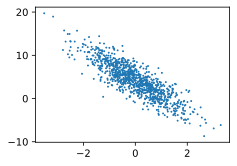

In [7]:
d2l.set_figsize()
# 某些torch版本需要detach才能转为numpy
d2l.plt.scatter(features[:, 1].detach().numpy(), 
                labels.detach().numpy(), 1)

## 数据load

In [8]:
# yield 每次返回一次数值，然后下次记得上次位置，从下个位置开始返回
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.2916, -0.5055],
        [ 0.7043, -0.0868],
        [ 0.4268, -1.4295],
        [ 0.8551, -1.5558],
        [-0.4228,  0.1234],
        [-0.3581, -0.2031],
        [ 0.1091, -0.3386],
        [-0.1389,  0.2499],
        [-0.0329, -0.0034],
        [-0.4023, -1.2714]]) 
 tensor([[ 5.3384],
        [ 5.8860],
        [ 9.9321],
        [11.2042],
        [ 2.9451],
        [ 4.1908],
        [ 5.5724],
        [ 3.0692],
        [ 4.1577],
        [ 7.7287]])


## 定义初始化模型

In [9]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [10]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 定义损失函数

In [11]:
def square_loss(y_hat, y):
    """均方损失函数"""
    # 个数应该一样，但是可能是行或者列向量，为了保持一致
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## 定义优化算法

In [12]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            # 这里的batch可以放在loss上面也行，因为乘法是线性关系，放这里也可以
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练过程

In [13]:
lr = 0.03
num_epochs = 3
net = linreg 
loss = square_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) 
        # 由于l的形状是（batch_size, 1）,而不是一个标量，1中所有元素加到一起，成为标量方便求梯度
        # 并以此来计算W b梯度
        l.sum().backward()
        # 这里的batch_size 在最后一个batch不能整除时候，可能会导致多点，作为示例没关系，其实只是求梯度均值
        # 因为之前的梯度是求和的
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新
    with torch.no_grad():
        # 这里取得features是对整个数据集上的运算
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.032803
epoch 2, loss 0.000113
epoch 3, loss 0.000050


## 参考误差

In [14]:
print(f'w的估计值： {true_w - w.reshape(true_w.shape)}')
print(f'b的估计值： {true_b - b}')

w的估计值： tensor([ 0.0002, -0.0002], grad_fn=<SubBackward0>)
b的估计值： tensor([0.0009], grad_fn=<RsubBackward1>)


In [15]:
w, b

(tensor([[ 1.9998],
         [-3.3998]], requires_grad=True),
 tensor([4.1991], requires_grad=True))

In [16]:
labels.shape

torch.Size([1000, 1])

# 线性回归的简洁实现

In [30]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [31]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [32]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch的数据迭代器"""
    # 这里 * 表示元组()类型不定参数，** 表示字典类型不定参数{}
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [33]:
next(iter(data_iter))

[tensor([[-0.2680, -0.1896],
         [ 0.8216, -0.1532],
         [ 0.1283,  1.4641],
         [ 0.6922,  0.0180],
         [-0.3364, -0.5369],
         [ 3.0922,  1.6633],
         [ 0.0709, -0.2216],
         [-2.1487, -0.6275],
         [-0.0794,  1.0058],
         [ 1.5399, -1.4611]]),
 tensor([[ 4.2964],
         [ 6.3717],
         [-0.5163],
         [ 5.5255],
         [ 5.3560],
         [ 4.7502],
         [ 5.0976],
         [ 2.0509],
         [ 0.6154],
         [12.2618]])]

## 用框架的预定义好的层

In [34]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [35]:
net

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

## 初始化模型参数

In [36]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## 计算均分误差使用的MSELoss类，也成平方L2范数

In [37]:
loss = nn.MSELoss()

## 实例化SGD实例

In [41]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 训练代码

In [52]:
num_epochs = 3
for eopch in range(num_epochs):
    for X,y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1},  loss {l:f}')


epoch 3,  loss 0.000106
epoch 3,  loss 0.000106
epoch 3,  loss 0.000106


In [43]:
true_w - net[0].weight.data

tensor([[-4.9400e-04, -6.8188e-05]])

In [44]:
true_b - net[0].bias

tensor([0.0011], grad_fn=<RsubBackward1>)